In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/zoujingyi/Desktop/EDA/HI-Small_Trans.csv')

## Without Feature engineering - can't run

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Prepare dataset for XGBoost
df = df.dropna(subset=['Is Laundering'])  # Drop missing target values

# Select features and target variable
X = df.drop(columns=['Is Laundering'])
y = df['Is Laundering']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train XGBoost model
num_round = 100
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_round, evals, early_stopping_rounds=10, verbose_eval=True)

# Predict and evaluate
preds = model.predict(dtest)
pred_labels = (preds > 0.5).astype(int)

accuracy = accuracy_score(y_test, pred_labels)
auc = roc_auc_score(y_test, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

## With 2 covariate

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd
import numpy as np

# Step 1: Prepare data
# Sample 0.1% of the data
df_sampled = df.sample(frac=1, random_state=42)

# Convert Timestamp to numerical feature
df_sampled['Timestamp'] = pd.to_datetime(df_sampled['Timestamp']).astype(int) / 10**9  # Convert to Unix timestamp

# Convert Payment Format to numerical codes
df_sampled['Payment Format'] = df_sampled['Payment Format'].astype('category').cat.codes

# Select features and target
X = df_sampled[['Timestamp', 'Payment Format']]
y = df_sampled['Is Laundering']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert dataset into DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 8,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train XGBoost model
num_round = 50
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_round, evals, early_stopping_rounds=5, verbose_eval=True)

# Predict and evaluate
preds = model.predict(dtest)
pred_labels = (preds > 0.5).astype(int)

accuracy = accuracy_score(y_test, pred_labels)
auc = roc_auc_score(y_test, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

/Users/zoujingyi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.87352	test-auc:0.87683
[1]	train-auc:0.89533	test-auc:0.89687
[2]	train-auc:0.89533	test-auc:0.89687
[3]	train-auc:0.89539	test-auc:0.89700
[4]	train-auc:0.87975	test-auc:0.88105
[5]	train-auc:0.89539	test-auc:0.89700
[6]	train-auc:0.89539	test-auc:0.89700
[7]	train-auc:0.89539	test-auc:0.89700
Accuracy: 0.9989
AUC: 0.8970


### 2 Covairate + Balance Data

[0]	train-auc:0.88642	test-auc:0.87968
[1]	train-auc:0.91065	test-auc:0.89458
[2]	train-auc:0.90814	test-auc:0.88807
[3]	train-auc:0.89436	test-auc:0.86543
[4]	train-auc:0.87699	test-auc:0.84735
[5]	train-auc:0.90940	test-auc:0.88818
Accuracy: 0.8551
AUC: 0.8942


/Users/zoujingyi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


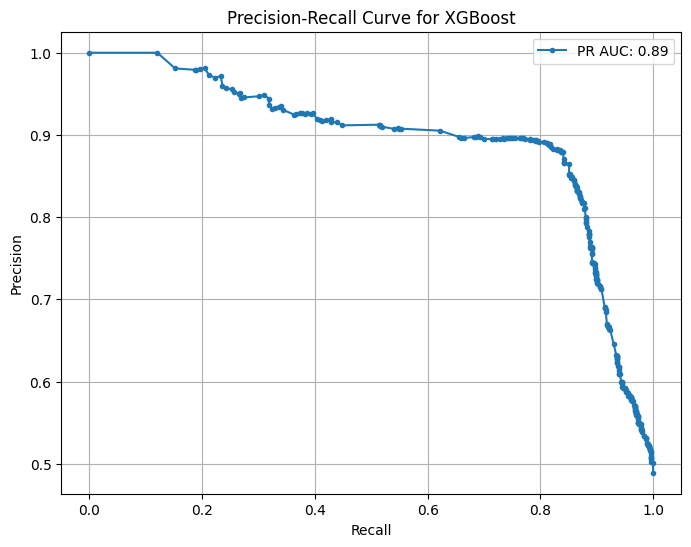

In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare data
# Sample 0.1% of the data
df_sampled = df

# Convert Timestamp to numerical feature
df_sampled['Timestamp'] = pd.to_datetime(df_sampled['Timestamp']).astype(int) / 10**9  # Convert to Unix timestamp

# Convert Payment Format to numerical codes
df_sampled['Payment Format'] = df_sampled['Payment Format'].astype('category').cat.codes

# Select features and target
X = df_sampled[['Timestamp', 'Payment Format']]
y = df_sampled['Is Laundering']

# Step 2: Balance the dataset using undersampling
df_minority = df_sampled[df_sampled['Is Laundering'] == 1]  # All illicit cases
df_majority = df_sampled[df_sampled['Is Laundering'] == 0].sample(n=len(df_minority), random_state=42)  # Sample same number of licit cases
df_balanced = pd.concat([df_majority, df_minority])

X_balanced = df_balanced[['Timestamp', 'Payment Format']]
y_balanced = df_balanced['Is Laundering']

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Convert dataset into DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 8,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train XGBoost model
num_round = 50
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_round, evals, early_stopping_rounds=5, verbose_eval=True)

# Predict and evaluate
preds = model.predict(dtest)
pred_labels = (preds > 0.5).astype(int)

accuracy = accuracy_score(y_test, pred_labels)
auc_score = roc_auc_score(y_test, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc_score:.4f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, preds)
pr_auc = auc(recall, precision)

# Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR AUC: {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost')
plt.legend()
plt.grid()
plt.show()

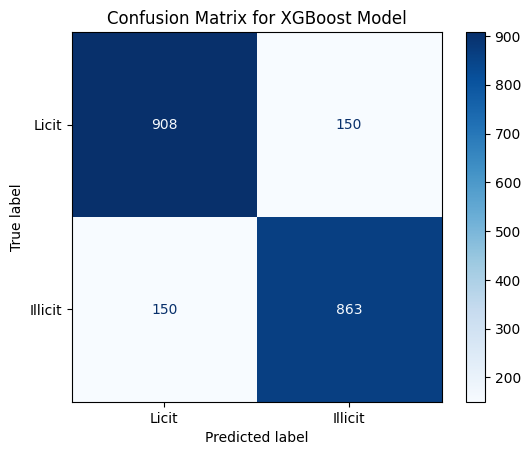

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, pred_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Licit", "Illicit"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for XGBoost Model")
plt.show()